In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MNIST

## data augmentation

## split data into train and validation

## Converlutional Neural Network

In [2]:
import torch

In [3]:
# Load the data
data = pd.read_csv('train-minst.csv')
# data = pd.read_csv('test-minst.csv') # only for architecture building
label = data['label']
data = data.values[:, 1:]
data = data.reshape(data.shape[0], 28, 28)


1


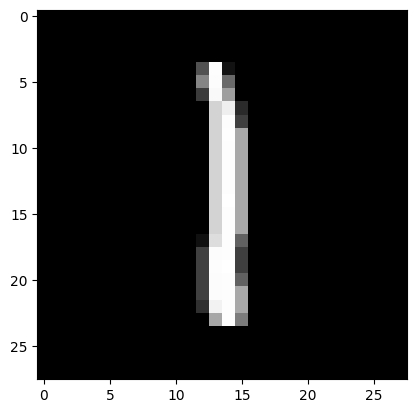

In [4]:
n = 1000
plt.imshow(data[n], cmap='gray')
print(label[n])

## cross validation

## super parameter (n_layer, stoppinh criteria, con_kernal)

## Loss function

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32*7*7, 128)
        self.fc2 = torch.nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32*7*7)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
Net = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001)

data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
label = torch.tensor(label, dtype=torch.long)

# move the model to GPU
Net = Net.cuda()
criterion = criterion.cuda()
data = data.cuda()
label = label.cuda()


for epoch in range(200):
    optimizer.zero_grad()
    output = Net(data)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

# Save the model
torch.save(Net.state_dict(), 'model.pth')

# Load the model
Net = CNN()
Net.load_state_dict(torch.load('model.pth'))

# Test the model
data = pd.read_csv('train-minst.csv')
data = data.values[:, 1:]
data = data.reshape(data.shape[0], 28, 28)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)

output = Net(data)
output = torch.argmax(output, dim=1)
output = output.numpy()

df = pd.DataFrame(output, columns=['label'])
df.index.name = 'id'
df.to_csv('output.csv')


Epoch: 0, Loss: 12.782937049865723
Epoch: 1, Loss: 13.440282821655273
Epoch: 2, Loss: 16.70424461364746
Epoch: 3, Loss: 12.112531661987305
Epoch: 4, Loss: 9.047890663146973
Epoch: 5, Loss: 5.775685787200928
Epoch: 6, Loss: 4.835099220275879
Epoch: 7, Loss: 4.720396518707275
Epoch: 8, Loss: 4.398662090301514
Epoch: 9, Loss: 3.693903923034668
Epoch: 10, Loss: 2.888331174850464
Epoch: 11, Loss: 2.266852617263794
Epoch: 12, Loss: 1.8493179082870483
Epoch: 13, Loss: 1.5936979055404663
Epoch: 14, Loss: 1.4534045457839966
Epoch: 15, Loss: 1.3755587339401245
Epoch: 16, Loss: 1.3122528791427612
Epoch: 17, Loss: 1.2432700395584106
Epoch: 18, Loss: 1.168607234954834
Epoch: 19, Loss: 1.0960726737976074
Epoch: 20, Loss: 1.0278412103652954
Epoch: 21, Loss: 0.9670742154121399
Epoch: 22, Loss: 0.915435254573822
Epoch: 23, Loss: 0.871012270450592
Epoch: 24, Loss: 0.8298389911651611
Epoch: 25, Loss: 0.7890974879264832
Epoch: 26, Loss: 0.7477770447731018
Epoch: 27, Loss: 0.7048733234405518
Epoch: 28, Los

/tmp/ipykernel_19205/3776535719.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Net.load_state_dict(torch.load('model.pth'))


In [7]:
data = pd.read_csv('train-minst.csv')
data = data.values[:, 0]
# 合并两个数组
data = np.vstack((data, output))

In [8]:
with open('comp.csv', 'w') as f:
    f.write('true,pred\n')
    for i in range(data.shape[1]):
        f.write('{},{}\n'.format(data[0, i], data[1, i]))

In [9]:
# Calculate the accuracy
with open('comp.csv', 'r') as f:
    lines = f.readlines()
    correct = 0
    total = 0
    for line in lines[1:]:
        true, pred = line.strip().split(',')
        if true == pred:
            correct += 1
        total += 1
    print('Accuracy: {}'.format(correct/total))

Accuracy: 0.9873095238095239


## speed of convergerce

## PCA

## BSSMF

### 分解后得10列矩阵，由1～0全部拆开，1全部相加取平均，2同理，10个数分别做一个预测，差距最小的为预测值。